In [40]:
import glob # поиск файлов, удовлетворающих условию
import os
import unicodedata
import string
import io

Рекуррентные нейронные сети позволяют предсказывать информацию в контексте, обращаясь к предыдущему элементу. Любой шаблон, передаваемый по узлам сети, запоминает информацию во время своего пути

Импорт датасета

In [41]:
for i in glob.glob('/content/drive/MyDrive/Colab Notebooks/data/names/*txt'): # перебор всех файлов
  print(len(open(i).readlines()))


298
2000
232
139
709
94
74
268
203
9408
991
73
519
3668
100
277
724
297


Для начала нужно добавить функцию для перевода символов из Unicode в Ascii, что позволит уменьшить разброс классификации, сужая круг поиска класса. То есть сеть не будте различать символы, различающиеся апострофами, так как они встречаются редко. (строка 5).

Далее создадим словарь category_lines, ключи в котором будут представлять язык, а значения - списки с именами, и список с языками all_categories, состоящий из языков из датасета

In [60]:
all_letters = string.ascii_letters + " .,;'" # метод возвращает строку с символами обоих регистров и конкатенирует их
n_letters = len(all_letters)
print('Символы: ', all_letters)

def unicodeToAscii(s): # функция заменяет символы на стандартные из unicode
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Śáý'))

# Создадим словарь category_lines и список с языками all_categories
category_lines = {}
all_categories = []

# разделение файла на строки
def readLines(filename):
    lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('/content/drive/MyDrive/Colab Notebooks/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] # считывание названия файла для классификации
    all_categories.append(category) # добавление категории в список
    lines = readLines(filename) # помещение всех строк в список (readlines)
    category_lines[category] = lines # добавление имени в словарь к соответствующему ключу category

n_categories = len(all_categories)
print('Количество языков:', len(category_lines))

Символы:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Say
Количество языков: 18


Теперь в словаре category_lines содержатся все языки из файла в виде ключей, а также все имена в списке в виде значений

In [43]:
# список ключей (языков)
for i in category_lines:
    (print(i, len(category_lines.get(i)), end=' '))

Spanish 298 Arabic 2000 Irish 232 Polish 139 Italian 709 Korean 94 Portuguese 74 Chinese 268 Greek 203 Russian 9408 Japanese 991 Vietnamese 73 Czech 519 English 3668 Scottish 100 French 277 German 724 Dutch 297 

Далее добавим функции для слоев сети. Сначала функцию для добавления индекса буквы (строка 4), затем для представления буквы в виде одномерной матрицы с нулевыми значениями остальных букв (8), и затем функцию для создания двумерной матрицы, каждый слой которой будет состоять из матрицы, созданной предыдущей определенной нами функцией, для каждой буквы слова. Так функция lineToTensor позволит представить слово в виде такой матрицы. Ее размеры - длина слова на 1 на 57(количество зарегистрированных ранее в нашей системе символов)

<h4>после организации имен нуужно превращать их в матрицы, чтобы продолжать с ними работать. Для преобразования слова используется одномерный вектор 1 x 57 (кол-во букв или n_letters).
</br>
Для преобращования слов вектоар складываются в двумерную матрицу:
длина вектора x 1 x кол-во букв
В данном случае одиночный парамтер длины матрицы - технический нюанс
</h4>

In [44]:
 import torch
# letterToIndex - позиция буквы в алфавите
# letterToTensor - матрица из слова
# lineToTensor - слово в трехмерной матрице
# функция для определения позиции буквы в местном алфавите (all_letters). Аналог ord (косвенно)
def letterToIndex(letter):
    return all_letters.find(letter)

# добавление буквы в Тензор (одномерная матрица)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters) # возвращает матрицу 1 на n_latters
    tensor[0][letterToIndex(letter)] = 1 # индекс порядкового места буквы заменяется на 1
    return tensor


def lineToTensor(line): # --> матрица [[a] на [b] на [c]], где
# a - коилчество символов в строке
# b - 1
# c - количество символов (57)
    tensor = torch.zeros(len(line), 1, n_letters) # двумерная матрица c нулевыми значениями
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print
print(lineToTensor('abbc').size())

torch.Size([4, 1, 57])


In [45]:
print(lineToTensor('acc').size())

torch.Size([3, 1, 57])


## Обучение

В  PyTorch уже есть готовый объект RNN, готовый к использованию

In [46]:
import torch.nn as nn
# класс с Pytorch
class RNN(nn.Module): # наследование базового класса
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size # количество функций в скрытом состоянии h
# следующие 3 строки - соединенные слои, как показано на диаграмме.
# представленный слой - объект nn.Linear. В качестве аргументов количество узлов в i и i + 1 слоях
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden): # фиктивный метод для движения по сети
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) # матрица 1 на 128 - скрытый узел

# первый слой - количество букв, второй слой -, третий - количество языков,
# так как их мы и будем классифицировать
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


пример архитектуры рекуррентной нейронной сети
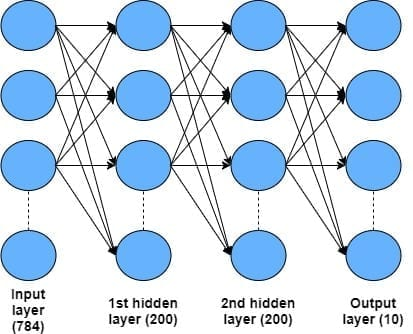

Для запуска сети нужно создать ввод буквы, функция вернет вероятности принадлежности каждой языковой группе и вероятность следующей буквы. <br>
В качестве аргумента функции zeros ипользуется скрытый слой(пока заполненный нулями) и номер буквы

In [47]:
input = letterToTensor('O')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(next_hidden)

tensor([[-2.9718, -2.8728, -2.8543, -2.8891, -2.8209, -2.8311, -2.9504, -2.9686,
         -2.7972, -2.9217, -3.0009, -2.8008, -2.8401, -2.9399, -2.9118, -2.9316,
         -2.9498, -2.8105]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-0.0007,  0.1242, -0.0664, -0.0281,  0.0261, -0.0464,  0.0323,  0.0020,
          0.0075, -0.0042,  0.0505,  0.1070, -0.1326,  0.0971, -0.0006,  0.0255,
          0.1001,  0.1061,  0.0624, -0.0174,  0.0587, -0.0168, -0.0044, -0.0498,
          0.0066,  0.0283, -0.0647,  0.0322,  0.0594, -0.1003, -0.0288,  0.0008,
         -0.0858, -0.0223, -0.0855, -0.0172, -0.0080, -0.0112, -0.0280, -0.0712,
          0.0934, -0.0896,  0.1089,  0.0325, -0.0628,  0.1037,  0.0668, -0.0439,
         -0.0393,  0.0304,  0.0494,  0.0669, -0.0080, -0.0482, -0.1301, -0.0555,
         -0.0246,  0.0506,  0.0438,  0.0817,  0.0226,  0.0010, -0.0257, -0.0022,
         -0.0425, -0.0583,  0.0580, -0.1307,  0.0132,  0.0126, -0.0108,  0.0322,
         -0.0124, -0.0057,  0.0088, -0.0131,  0.0

In [48]:
# в экземмпляре модели видна архитектура - первый узел - 57 букв + 128 элементов другого узла,
# далее 2 узла с размерностью 127 и 18
print(rnn)
print(n_letters, n_categories)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
57 18


Чтобы постоянно не создавать новйы тензор, можно воспользоваться написанной ранее функцией LineToTensor и использовать взятие по индексу или срезы. функция вернет вероятности принадлежности к языковым группам

In [49]:

input = lineToTensor('Ivan')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9932, -2.9050, -2.8069, -2.9231, -2.7966, -2.8188, -2.9870, -2.9157,
         -2.8028, -2.9700, -2.9802, -2.8323, -2.8209, -2.9381, -2.8984, -2.9315,
         -2.9478, -2.8025]], grad_fn=<LogSoftmaxBackward0>)


### Тренировка сети

Необходимо написать несколько вспомогательных функций. categoryFromOutput будет возвращать наивероятнейшую языковую группу и ее порядковый номер, основываясь на результате функции, записанной в output
</br>
Функция randomTrainingExample возвращает случайную языковую категорию, имя, тензор по языку и тензор по имени

In [50]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    print(output.topk(1))
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

torch.return_types.topk(
values=tensor([[-2.7966]], grad_fn=<TopkBackward0>),
indices=tensor([[4]]))
('Italian', 4)


In [51]:
import random
# функция для выбора случайного индекса списка
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
#
def randomTrainingExample():
    category = randomChoice(all_categories) # случайная языковая категория в переменной category
    line = randomChoice(category_lines[category]) # случайное имя в выбранном языке
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # тензор вида tensor([индекс группы])
    line_tensor = lineToTensor(line) # матрица 1 на 57 на длину имени
    return category, line, category_tensor, line_tensor

# Непосредственно тренировка
Для тенировки сети используется функция потерь - сеть делает выбор, после чего получает информацию о том, насколько он был верен, то есть о своей ошибке.</br>
Каждый тренировочный шаг будет создавать тензор для предсказывания результата и тензор, результатом являющимся, создавать скрытый слой сети для предугадывания следующей буквы и получать output и ошибку, так сеть смодет учиться.

In [52]:
criterion = nn.NLLLoss()

In [53]:
learning_rate = 0.005 # leraning rate - размер шага обучения при движении к минимуму функции потерь

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [54]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Осталось натренировать функцию после определения ф-и train. Благодарая тому, что функция train возвращает результат и потери, мы можем легко отследить средние потеи после тренировки

In [55]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Отслеживание состояния потерь
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))


    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

torch.return_types.topk(
values=tensor([[-1.6872]], grad_fn=<TopkBackward0>),
indices=tensor([[10]]))
5000 5% (0m 5s) 3.0529 Hassani / Japanese ✗ (English)
torch.return_types.topk(
values=tensor([[-0.9460]], grad_fn=<TopkBackward0>),
indices=tensor([[8]]))
10000 10% (0m 9s) 3.5875 Morcos / Greek ✗ (Arabic)
torch.return_types.topk(
values=tensor([[-1.4285]], grad_fn=<TopkBackward0>),
indices=tensor([[5]]))
15000 15% (0m 14s) 1.4852 See  / Korean ✗ (Chinese)
torch.return_types.topk(
values=tensor([[-0.8766]], grad_fn=<TopkBackward0>),
indices=tensor([[7]]))
20000 20% (0m 22s) 0.8766 Kang / Chinese ✓
torch.return_types.topk(
values=tensor([[-0.7687]], grad_fn=<TopkBackward0>),
indices=tensor([[11]]))
25000 25% (0m 28s) 0.7687 Thao / Vietnamese ✓
torch.return_types.topk(
values=tensor([[-0.2296]], grad_fn=<TopkBackward0>),
indices=tensor([[3]]))
30000 30% (0m 33s) 0.2296 Rutkowski / Polish ✓
torch.return_types.topk(
values=tensor([[-0.9649]], grad_fn=<TopkBackward0>),
indices=tensor([[1]])

#3

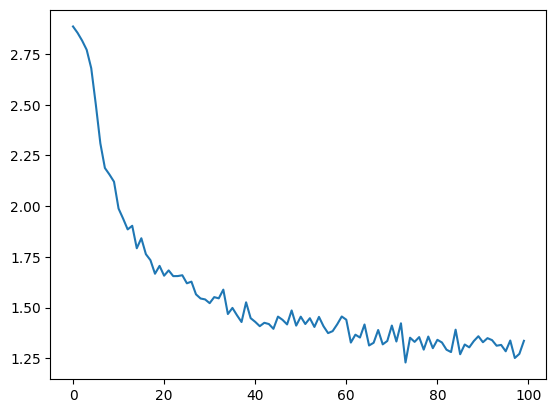

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Для анализа рещультата создается матрциа, показывающая, какой язык угадала нейросеть. Для этого используется аналогичная train функци evaluate. В матрице по горизонтали идут использованные языки, по вертикали - ответ нейросети

Streaming output truncated to the last 5000 lines.
values=tensor([[-0.3020]], grad_fn=<TopkBackward0>),
indices=tensor([[12]]))
torch.return_types.topk(
values=tensor([[-0.8949]], grad_fn=<TopkBackward0>),
indices=tensor([[6]]))
torch.return_types.topk(
values=tensor([[-0.4801]], grad_fn=<TopkBackward0>),
indices=tensor([[1]]))
torch.return_types.topk(
values=tensor([[-1.4237]], grad_fn=<TopkBackward0>),
indices=tensor([[16]]))
torch.return_types.topk(
values=tensor([[-1.7338]], grad_fn=<TopkBackward0>),
indices=tensor([[12]]))
torch.return_types.topk(
values=tensor([[-0.9249]], grad_fn=<TopkBackward0>),
indices=tensor([[1]]))
torch.return_types.topk(
values=tensor([[-0.3962]], grad_fn=<TopkBackward0>),
indices=tensor([[3]]))
torch.return_types.topk(
values=tensor([[-0.7335]], grad_fn=<TopkBackward0>),
indices=tensor([[4]]))
torch.return_types.topk(
values=tensor([[-0.8711]], grad_fn=<TopkBackward0>),
indices=tensor([[8]]))
torch.return_types.topk(
values=tensor([[-0.6856]], grad_fn=<T

<ipython-input-57-59cae0c54c29>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-57-59cae0c54c29>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


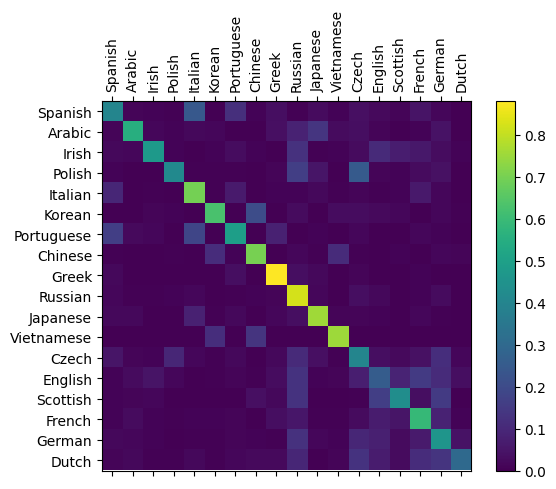

In [57]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
     output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


plt.show()

In [58]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.65) Czech
(-1.07) Russian
(-2.49) English

> Jackson
(-0.35) Russian
(-1.80) Czech
(-2.50) Scottish

> Satoshi
(-0.51) Japanese
(-1.32) Italian
(-2.59) Arabic


In [59]:
predict('Wong')


> Wong
(-1.48) Chinese
(-1.66) German
(-1.73) Scottish
